<img src="https://i.ibb.co/x65XC1B/banner-2.png" align="center"/>


In [1]:
#@title 1. MONTAR EL DRIVE { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Cardiotocography_classification')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Cardiotocography_classification


In [2]:
#@title 2. CARGAR LIBRERIAS { display-mode: "form" }
import scipy.stats as stats
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from matplotlib.pyplot import figure
import tensorflow as tf
from tensorflow import keras
!pip install imblearn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


El proyecto está hecho en base a un dataset denominado "Cardiotocography Data Set".

*   El dataset se encuentra en el siguiente enlace: https://archive.ics.uci.edu/ml/datasets/Cardiotocography




In [3]:
#Importamos el dataframe
d =pd.read_excel("data/CTG.xls","Datos")
print(d.shape)
d.head()

(2126, 40)


,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,DR,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,A,B,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,1996-12-01,CTG0001.txt,240,357,120,120,0,0,0,73,0.5,43,2.4,0,0,0,0,64,62,126,2,0,120,137,121,73,1,0,0,0,0,0,0,0,0,1,0,9,2
1,Fmcs_1.txt,1996-05-03,CTG0002.txt,5,632,132,132,4,0,4,17,2.1,0,10.4,2,0,0,0,130,68,198,6,1,141,136,140,12,0,0,0,0,0,0,1,0,0,0,0,6,1
2,Fmcs_1.txt,1996-05-03,CTG0003.txt,177,779,133,133,2,0,5,16,2.1,0,13.4,2,0,0,0,130,68,198,5,1,141,135,138,13,0,0,0,0,0,0,1,0,0,0,0,6,1
3,Fmcs_1.txt,1996-05-03,CTG0004.txt,411,1192,134,134,2,0,6,16,2.4,0,23.0,2,0,0,0,117,53,170,11,0,137,134,137,13,1,0,0,0,0,0,1,0,0,0,0,6,1
4,Fmcs_1.txt,1996-05-03,CTG0005.txt,533,1147,132,132,4,0,5,16,2.4,0,19.9,0,0,0,0,117,53,170,9,0,137,136,138,11,1,0,1,0,0,0,0,0,0,0,0,2,1


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocesamiento

Ante todo, se deben eliminar las columnas innecesarias del dataset, ya que pueden llegar a aportar de forma negativa los resultados.

In [5]:
df = d.drop(['FileName', 'Date', 'SegFile', 'b', 'e', 'A', 'B', 'C','D','E','AD','DE','LD','FS','SUSP','CLASS', 'LBE', 'DR', 'DS', 'DP', 'Mode', 'Median'], axis=1)
df.head()

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,Width,Min,Max,Nmax,Nzeros,Mean,Variance,Tendency,NSP
0,120,0,0,0,73,0.5,43,2.4,0,64,62,126,2,0,137,73,1,2
1,132,4,0,4,17,2.1,0,10.4,2,130,68,198,6,1,136,12,0,1
2,133,2,0,5,16,2.1,0,13.4,2,130,68,198,5,1,135,13,0,1
3,134,2,0,6,16,2.4,0,23.0,2,117,53,170,11,0,134,13,1,1
4,132,4,0,5,16,2.4,0,19.9,0,117,53,170,9,0,136,11,1,1


Los label del dataset se encuentran en el rango del 1 al 3, para evitar confusiones y errores, se reasignan los valores con el numero anterior, es decir, ahora los label estarán en el rango de 0 a 2.

In [6]:
df['NSP'] = df['NSP'].replace([1],0)
df['NSP'] = df['NSP'].replace([2],1)
df['NSP'] = df['NSP'].replace([3],2)

<table style="margin:auto;"> 
<tbody>
  <tr>
    <th> Estado del paciente</th>
    <th> Label </th>
  </tr>
  <tr>
    <td> Normal </td>
    <td> 0 </td>
  </tr>
  <tr>
    <td> Sospechoso </td>
    <td> 1 </td>
  </tr>
  <tr>
    <td> Patológico </td>
    <td> 2 </td>
  </tr>

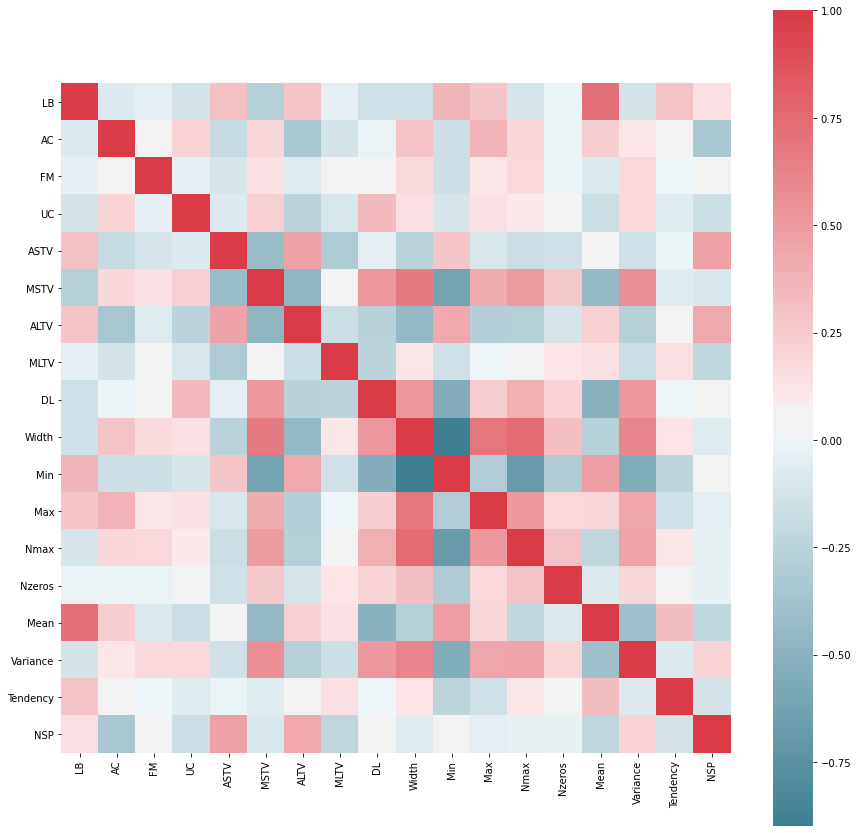

In [7]:
#@title 1. Correlación de los datos { display-mode: "form" }
import seaborn as sns

f, ax = plt.subplots(figsize=(15, 15))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [8]:
#Definimos x e y
x=df.values[:,:-1]
y=df.values[:,-1]
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2)

In [9]:
#Función de entrenamiento y test para un modelo

def run_model(est, x_train, x_test, y_train, y_test):
  est.fit(x_train,y_train)
  y_predict = est.predict(x_test)
  score=cross_val_score(est,x_test,y_test,cv=KFold(10,shuffle=True),scoring=make_scorer(accuracy_score))
  return est, y_predict, np.mean(score)

#Matriz de confusión

def matriz_confusion(y_test, y_predict):
    conf_matrix = confusion_matrix(y_test, y_predict)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, xticklabels=target, yticklabels=target, annot=True, fmt="d");
    plt.title("Matriz de confusión")
    plt.ylabel('Clase verdadera')
    plt.xlabel('Clase predicha')
    plt.show()
    print (classification_report(y_test, y_predict))
    return None

El balance de clases es un factor fundamental a la hora de iniciar un proyecto, no obstante, en áreas como la medicina, es muy común encontrar un gran desbalance en los datasets, debido a que la gran mayoría de exámenes realizados a personas dan un resultado negativo, es decir, el paciente no posee la patología.

Esto, se puede observar en el siguiente diagrama de barras, el cual corresponde al balance de clases del dataset utilizado.

1322
235
143


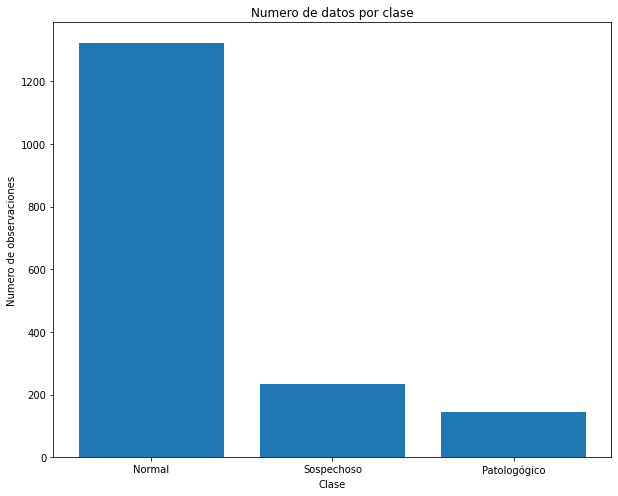

In [10]:
#@title 2. Balance de clases { display-mode: "form" }

target= ['Normal', 'Sospechoso', 'Patologógico']
lista = []
for i in range (0,3):
  values = np.sum(y_train==i)
  print(np.sum(y_train==i))
  lista.append(values)
figure(figsize=(10,8))
plt.bar(target, lista)
plt.title("Numero de datos por clase")
plt.xlabel("Clase")
plt.ylabel("Numero de observaciones");

Como se puede obsevar, existe un desbalance de clases significativo, lo cual representa un problema, no obstante, es pertinente realizar una prueba con un regresor para poder analizar los percances que pueden surgir.

### **Clasificación con árbol de decisión**



0.8805647840531561


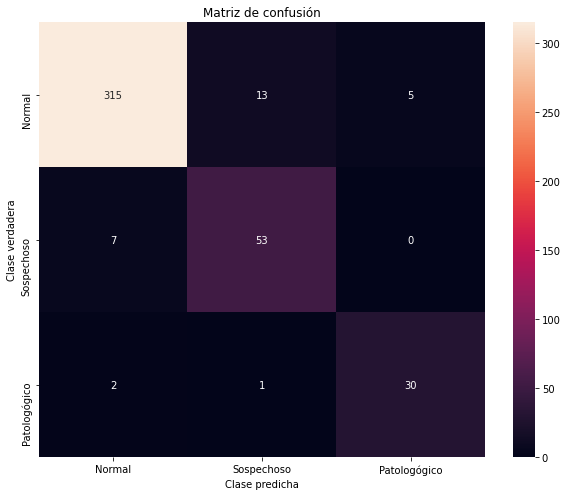

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       333
         1.0       0.79      0.88      0.83        60
         2.0       0.86      0.91      0.88        33

    accuracy                           0.93       426
   macro avg       0.87      0.91      0.89       426
weighted avg       0.94      0.93      0.94       426



In [24]:
estDT=DecisionTreeClassifier()
estDT, yDT_predict, scoreDT = run_model(estDT,x_train,x_test,y_train,y_test)
print(scoreDT)
matriz_confusion(y_test, yDT_predict)

Los resultados del score son muy buenos, teniendo un 87.5% de efectividad, no obstante, esta métrica de calificación no es la más óptima para evaluar un modelo en el campo de la medicina, debido a que, el interés del proyecto en general es poder detectar cuando un paciente posee o puede poseer una patología. Teniendo en cuenta el desbalance de clases, es correcto afirmar que la mayoría de predicciones que realizó el modelo corresponde a casos donde el paciente no posee la enfermedad, esto, se puede comprobar en la columna "Support", en donde 343 de los 426 casos son resultados "Normales".

Para poder evaluar correctamente el clasificador, se pueden evaluar otras métricas más sensibles, como lo son:


*   Precision
*   Recall
*   f1-score

En el caso anteriormente mostrado, se puede apreciar que la precisión en los casos de "Sospechoso" y "Patológico", es menor en relación a los casos "Normales". Para poder obtener un modelo más confiable y preciso, es necesario tener un balance de clases.


### Oversampling

Para poder realizar un balance de clases, se tienen dos opciones, eliminar filas de la clase dominante, o crear muestras artificiales de las clases que representan una minoría. En este proyecto, es más acertado aplicar la última opción mencionada, debido a que si se eliminan filas de la clase dominante, se obtendrían pocas muestras en general, lo cual representa una desventaja en el modelo final, ya que se corre el riesgo de no obtener una generalización del problema.

Para esto, se utilizará la Técnica de sobremuestreo de minorías sintéticas , o SMOTE.

In [12]:
smote=SMOTE()
x_res, y_res = smote.fit_sample(x,y)
x_train_res, x_test_res, y_train_res, y_test_res = train_test_split(x_res,y_res,test_size=0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


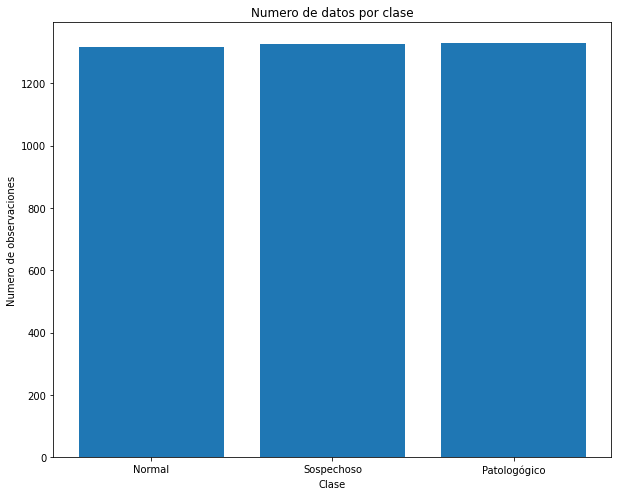

In [13]:
#@title 1. Balance de clases con oversampling { display-mode: "form" }
lista = []
for i in range (0,3):
  values = np.sum(y_train_res==i)
  lista.append(values)
figure(figsize=(10,8))
plt.bar(target, lista)
plt.title("Numero de datos por clase")
plt.xlabel("Clase")
plt.ylabel("Numero de observaciones");

Luego del sobremuestreo, es evidente el cambio en el balance de clases, por lo tanto, habrá un número de predicciones más equitativo para cada clase.

0.9203838383838384


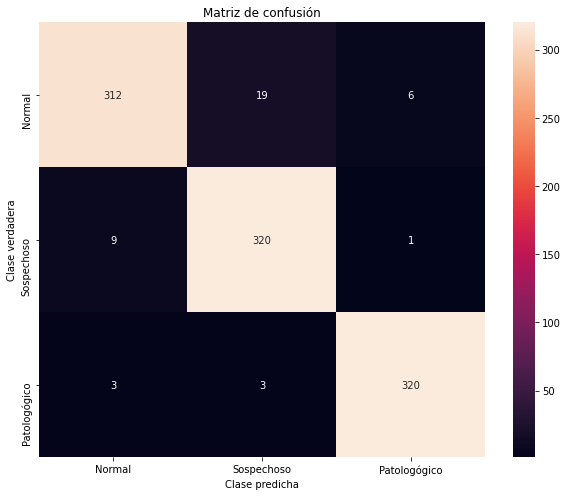

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94       337
         1.0       0.94      0.97      0.95       330
         2.0       0.98      0.98      0.98       326

    accuracy                           0.96       993
   macro avg       0.96      0.96      0.96       993
weighted avg       0.96      0.96      0.96       993



In [14]:
estDTBR = DecisionTreeClassifier()
estDTBR, yDTBR_predict, scoreDTBR = run_model(estDTBR,x_train_res,x_test_res,y_train_res,y_test_res)
print(scoreDTBR)
matriz_confusion(y_test_res, yDTBR_predict)

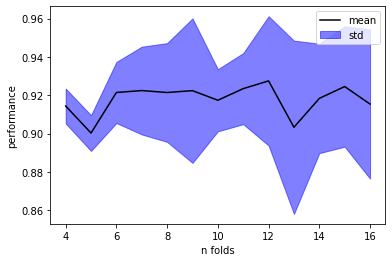

In [15]:
#@title 5. Puntaje del modelo según el KFold { display-mode: "form" }
means, stds = [], []
est = DecisionTreeClassifier()
est.fit(x_train_res, y_train_res)
nfolds_range = range(4,17)
for nfolds in nfolds_range:
    #print (nfolds,)
    s = cross_val_score(est, x_test_res, y_test_res, cv=KFold(nfolds, shuffle=True), scoring=make_scorer(accuracy_score))
    means.append(np.mean(s))
    stds.append(np.std(s))

means = np.r_[means]
stds  = np.r_[stds]
plt.plot(nfolds_range, means, label="mean", color="black")
plt.fill_between(nfolds_range, means-stds, means+stds, color="blue", alpha=.5, label="std")
plt.xlabel("n folds")
plt.ylabel("performance")
plt.legend()

# Pruebas de clasificación

###Prueba con Support Vector Machine

0.8327070707070707


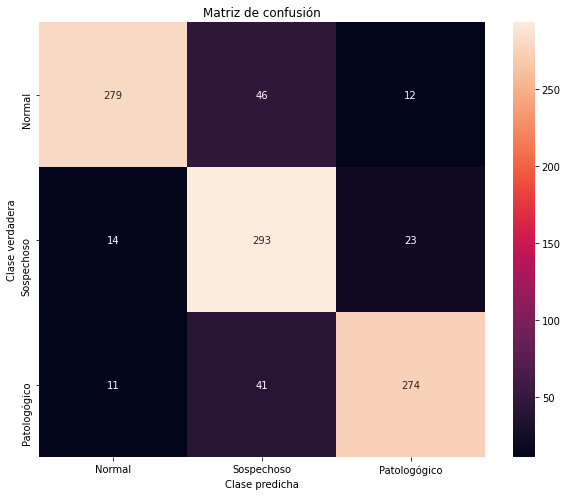

              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87       337
         1.0       0.77      0.89      0.83       330
         2.0       0.89      0.84      0.86       326

    accuracy                           0.85       993
   macro avg       0.86      0.85      0.85       993
weighted avg       0.86      0.85      0.85       993



In [16]:
estSV = SVC()
estSV, ySV_predict, scoreSV = run_model(estSV,x_train_res,x_test_res,y_train_res,y_test_res)
print(scoreSV)
matriz_confusion(y_test_res, ySV_predict)

###Prueba con Random Forest

In [26]:
importances = estRF.feature_importances_
print(importances)

[0.07454443 0.09919761 0.02274176 0.02254157 0.16266472 0.05610872
 0.14862136 0.06945621 0.0131646  0.0266441  0.02998822 0.03182039
 0.01634522 0.00451426 0.15479298 0.04702667 0.01982717]


0.9506363636363636


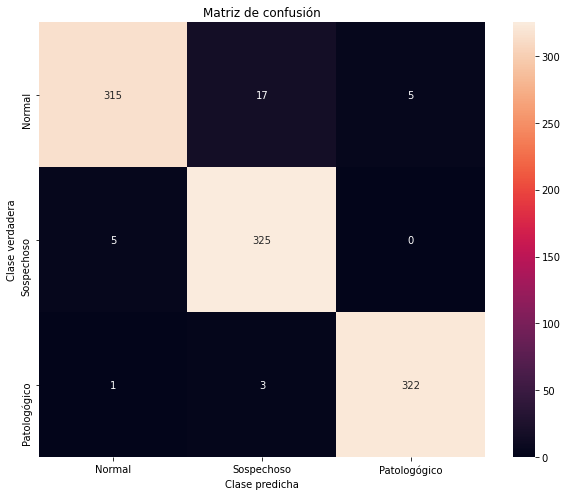

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96       337
         1.0       0.94      0.98      0.96       330
         2.0       0.98      0.99      0.99       326

    accuracy                           0.97       993
   macro avg       0.97      0.97      0.97       993
weighted avg       0.97      0.97      0.97       993



In [17]:
estRF = RandomForestClassifier()
estRF, yRF_predict, scoreRF = run_model(estRF,x_train_res,x_test_res,y_train_res,y_test_res)
print(scoreRF)
matriz_confusion(y_test_res, yRF_predict)

###Red Neuronal

In [18]:
#@title 6. Reiniciar el modelo { display-mode: "form" }
keras.backend.clear_session()

In [19]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape= (x_train_res[0].shape)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [20]:
model.compile(optimizer= tf.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
model.fit(x_train_res, y_train_res, epochs=200)

Epoch 1/200
125/125 [==============================] - 0s 2ms/step - loss: 1.6683 - accuracy: 0.7122
Epoch 2/200
125/125 [==============================] - 0s 2ms/step - loss: 0.6795 - accuracy: 0.7835
Epoch 3/200
125/125 [==============================] - 0s 2ms/step - loss: 0.6245 - accuracy: 0.8066
Epoch 4/200
125/125 [==============================] - 0s 2ms/step - loss: 0.6253 - accuracy: 0.7986
Epoch 5/200
125/125 [==============================] - 0s 2ms/step - loss: 0.5663 - accuracy: 0.8218
Epoch 6/200
125/125 [==============================] - 0s 2ms/step - loss: 0.3773 - accuracy: 0.8565
Epoch 7/200
125/125 [==============================] - 0s 2ms/step - loss: 0.3531 - accuracy: 0.8663
Epoch 8/200
125/125 [==============================] - 0s 2ms/step - loss: 0.3535 - accuracy: 0.8668
Epoch 9/200
125/125 [==============================] - 0s 2ms/step - loss: 0.3441 - accuracy: 0.8623
Epoch 10/200
125/125 [==============================] - 0s 2ms/step - loss: 0.2991 - accura

32/32 [==============================] - 0s 2ms/step - loss: 0.1826 - accuracy: 0.9507
0.9506545662879944


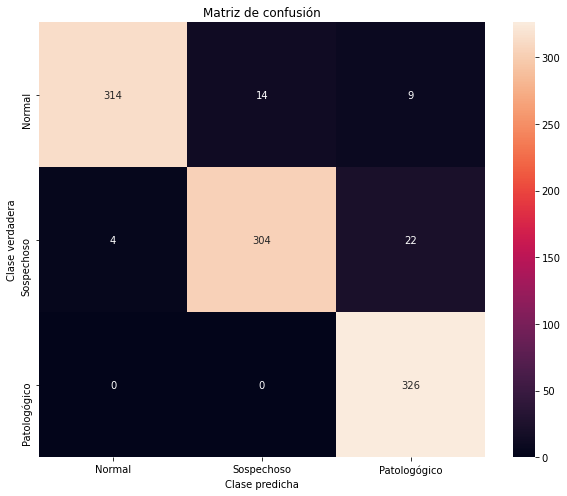

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       337
         1.0       0.96      0.92      0.94       330
         2.0       0.91      1.00      0.95       326

    accuracy                           0.95       993
   macro avg       0.95      0.95      0.95       993
weighted avg       0.95      0.95      0.95       993



In [22]:
test_loss, test_acc = model.evaluate(x_test_res, y_test_res)
y_prob = model.predict(x_test_res) 
y_predict_res = y_prob.argmax(axis=-1)
print(test_acc)
matriz_confusion(y_test_res, y_predict_res)

# ¿Es necesario aplicar PCA?

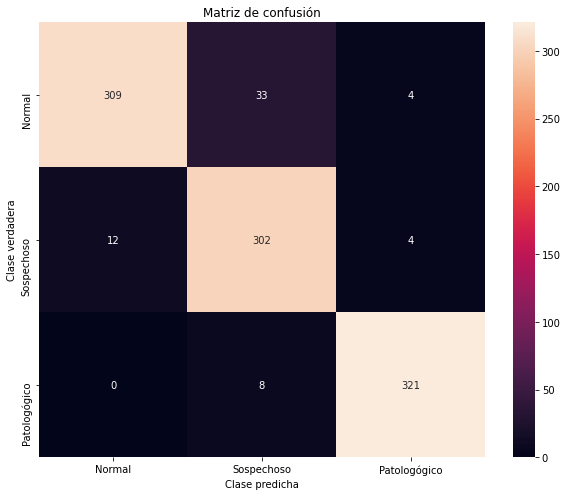

              precision    recall  f1-score   support

         0.0       0.96      0.89      0.93       346
         1.0       0.88      0.95      0.91       318
         2.0       0.98      0.98      0.98       329

    accuracy                           0.94       993
   macro avg       0.94      0.94      0.94       993
weighted avg       0.94      0.94      0.94       993

Score: 0.8851717171717173


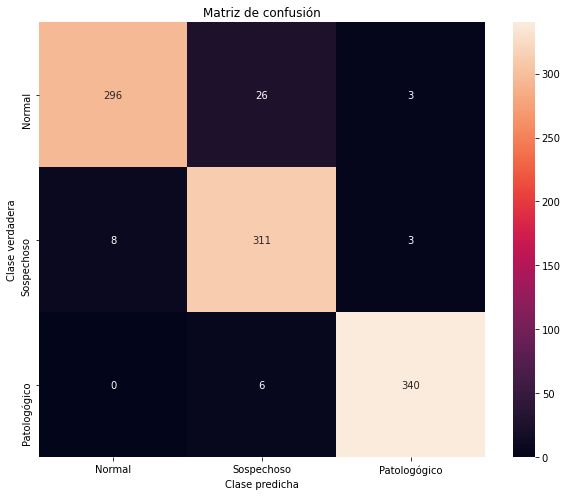

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94       325
         1.0       0.91      0.97      0.94       322
         2.0       0.98      0.98      0.98       346

    accuracy                           0.95       993
   macro avg       0.95      0.95      0.95       993
weighted avg       0.96      0.95      0.95       993

Score: 0.8922424242424242


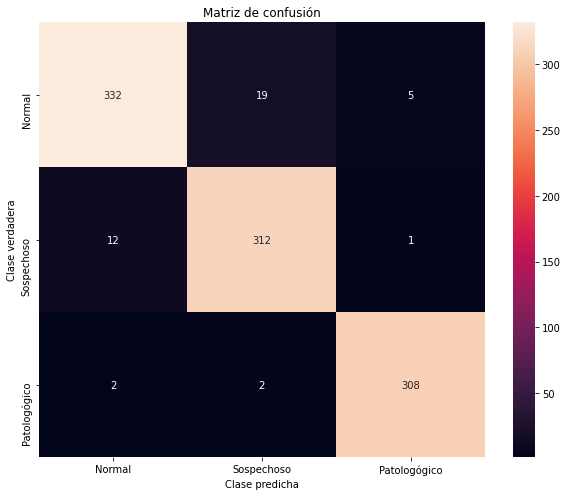

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95       356
         1.0       0.94      0.96      0.95       325
         2.0       0.98      0.99      0.98       312

    accuracy                           0.96       993
   macro avg       0.96      0.96      0.96       993
weighted avg       0.96      0.96      0.96       993

Score: 0.9063131313131312


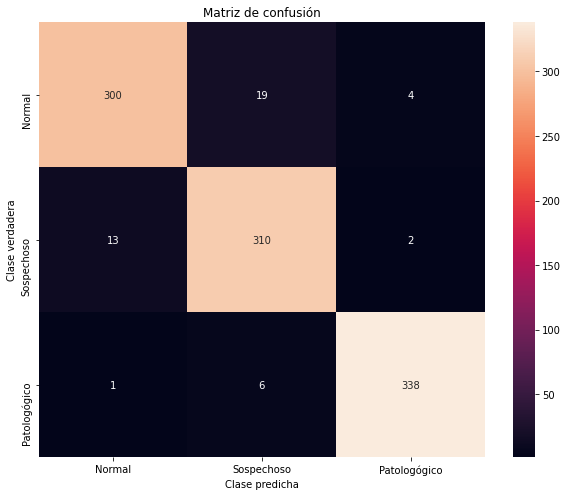

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94       323
         1.0       0.93      0.95      0.94       325
         2.0       0.98      0.98      0.98       345

    accuracy                           0.95       993
   macro avg       0.95      0.95      0.95       993
weighted avg       0.96      0.95      0.95       993

Score: 0.9083333333333334


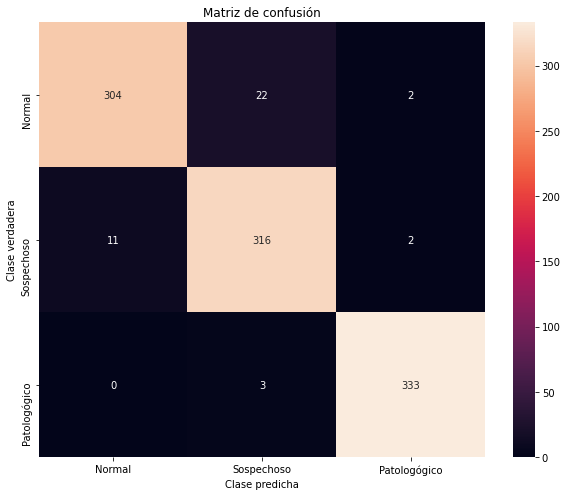

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       328
         1.0       0.93      0.96      0.94       329
         2.0       0.99      0.99      0.99       336

    accuracy                           0.96       993
   macro avg       0.96      0.96      0.96       993
weighted avg       0.96      0.96      0.96       993

Score: 0.9073333333333334


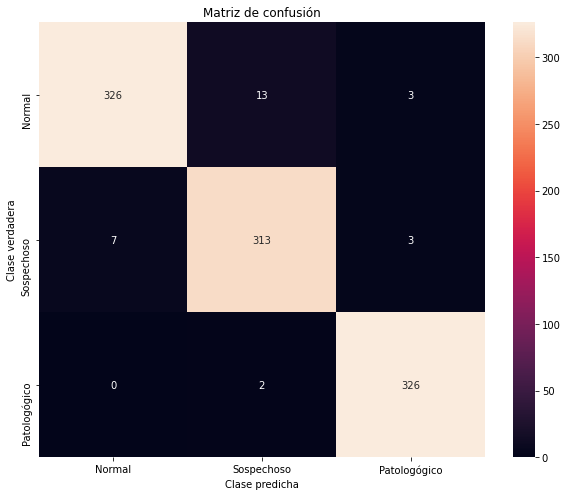

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97       342
         1.0       0.95      0.97      0.96       323
         2.0       0.98      0.99      0.99       328

    accuracy                           0.97       993
   macro avg       0.97      0.97      0.97       993
weighted avg       0.97      0.97      0.97       993

Score: 0.9183636363636365


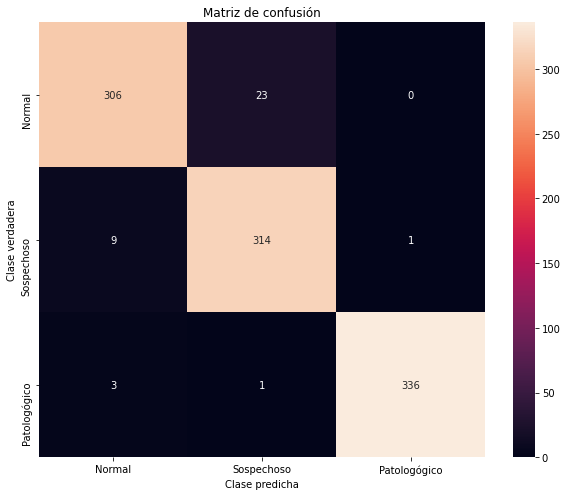

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95       329
         1.0       0.93      0.97      0.95       324
         2.0       1.00      0.99      0.99       340

    accuracy                           0.96       993
   macro avg       0.96      0.96      0.96       993
weighted avg       0.96      0.96      0.96       993

Score: 0.9265656565656567


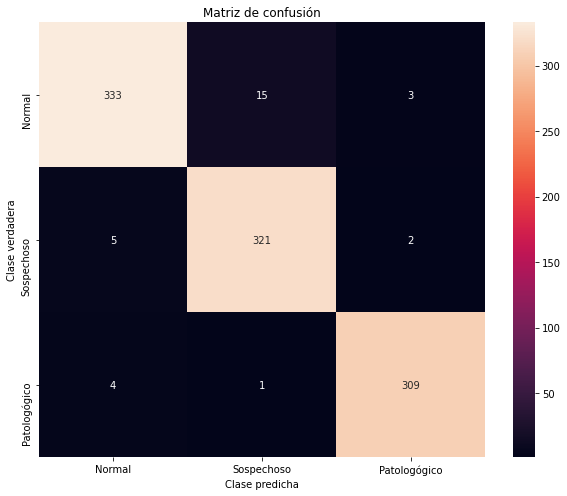

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       351
         1.0       0.95      0.98      0.97       328
         2.0       0.98      0.98      0.98       314

    accuracy                           0.97       993
   macro avg       0.97      0.97      0.97       993
weighted avg       0.97      0.97      0.97       993

Score: 0.9224949494949494


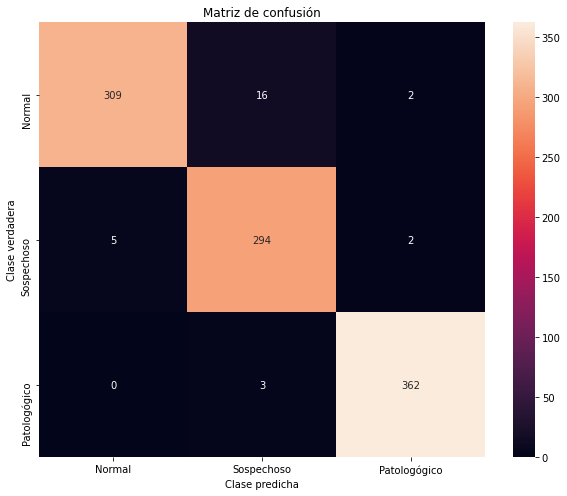

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96       327
         1.0       0.94      0.98      0.96       301
         2.0       0.99      0.99      0.99       365

    accuracy                           0.97       993
   macro avg       0.97      0.97      0.97       993
weighted avg       0.97      0.97      0.97       993

Score: 0.9305050505050506


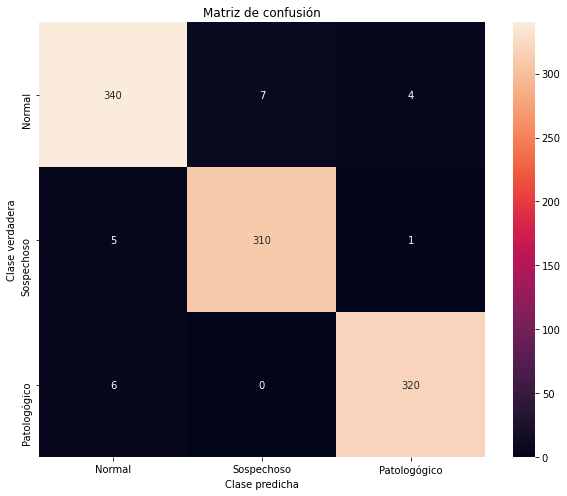

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       351
         1.0       0.98      0.98      0.98       316
         2.0       0.98      0.98      0.98       326

    accuracy                           0.98       993
   macro avg       0.98      0.98      0.98       993
weighted avg       0.98      0.98      0.98       993

Score: 0.9275353535353537


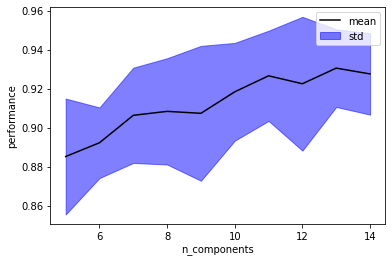

In [23]:
means, stds = [], []
pcac_range = range(5,15)
est = RandomForestClassifier()
for pcac in pcac_range:
    x_pca = PCA(n_components=pcac).fit_transform(x_res)
    x_train_pca,x_test_pca,y_train_pca,y_test_pca= train_test_split(x_pca,y_res,test_size=0.2,shuffle=True)
    est.fit(x_train_pca, y_train_pca)
    y_predict_pca= est.predict(x_test_pca)
    matriz_confusion(y_test_pca, y_predict_pca)
    s = cross_val_score(est, x_test_pca, y_test_pca, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    print("Score:", np.mean(s))
    means.append(np.mean(s))
    stds.append(np.std(s))

means = np.r_[means]
stds  = np.r_[stds]
plt.plot(pcac_range, means, label="mean", color="black")
plt.fill_between(pcac_range, means-stds, means+stds, color="blue", alpha=.5, label="std")
plt.xlabel("n_components")
plt.ylabel("performance")
plt.legend()